In [58]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
import dateutil
from datetime import datetime
import math
import plotly.graph_objects as go
import plotly.express as px


In [95]:
symbols = ['USD.FOREX','NZD.FOREX', 'GBPUSD.FOREX', 'CHFUSD.FOREX', 'JPYUSD.FOREX', 'AUDUSD.FOREX']
#symbols = ['LUV.US','AAL.US', 'DAL.US', 'UAL.US', 'ATSG.US', 'SKYW.US', 'ALGT.US', 'GD.US', 'ALK.US', 'HA.US']




# Get Data

In [96]:
quotes = pd.DataFrame()
#start = '2015-01-1' ## Anti correlated period - starts with a massive drop
start = '2016-01-1'
end = '2020-03-30'

In [97]:
for s in symbols:
    print(s)
    endpoint = f'https://eodhistoricaldata.com/api/intraday/{s}?api_token=5d7111a684ee90.02476162&fmt=csv'
    df = pd.read_csv(endpoint)
    #print(df)
    df = df[df['Adjusted_close'] > 0]
    #print(df.head(1))
    if len(quotes) == 0:
        quotes['Date'] = df['Datetime']
        quotes[s] = df['Adjusted_close']
    else:
        new_df = pd.DataFrame()
        new_df['Date'] = df['Datetime']
        new_df[s] = df['Adjusted_close']
        quotes = quotes.merge(new_df, how="inner", on="Date")
    #print(quotes)
#print(quotes.tail(20))

USD.FOREX
NZD.FOREX
GBPUSD.FOREX
CHFUSD.FOREX
JPYUSD.FOREX
AUDUSD.FOREX


In [75]:
old_quotes = quotes
#quotes=old_quotes

#print(quotes)


In [76]:
quotes = quotes.dropna()
quotes = quotes.reset_index()
quotes['Date'] = pd.to_datetime(quotes['Date'])
quotes = quotes.set_index('Date')
#quotes = quotes[quotes.index > dateutil.parser.parse("2020-03-01")]
#print(quotes)

# Understand cointegration

In [77]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

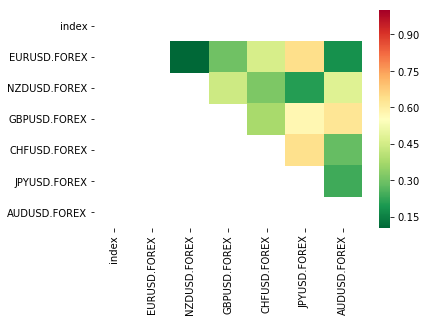

[]


In [78]:
data = quotes
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=data.columns, 
                yticklabels=data.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.80)
                )
plt.show()
print(pairs)


### Initial analysis of ratio and zscore. Do they go back to a mean?

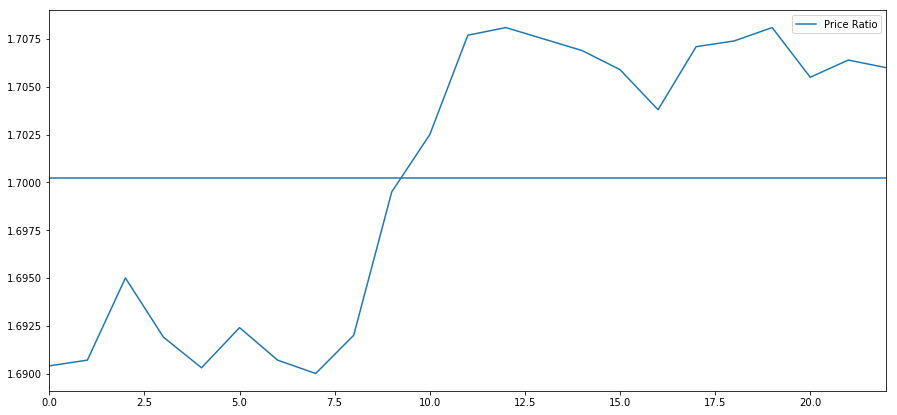

In [98]:
chosen = ['NZD.FOREX', 'USD.FOREX']
S1 = quotes[chosen[0]]
S2 = quotes[chosen[1]]

score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [99]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

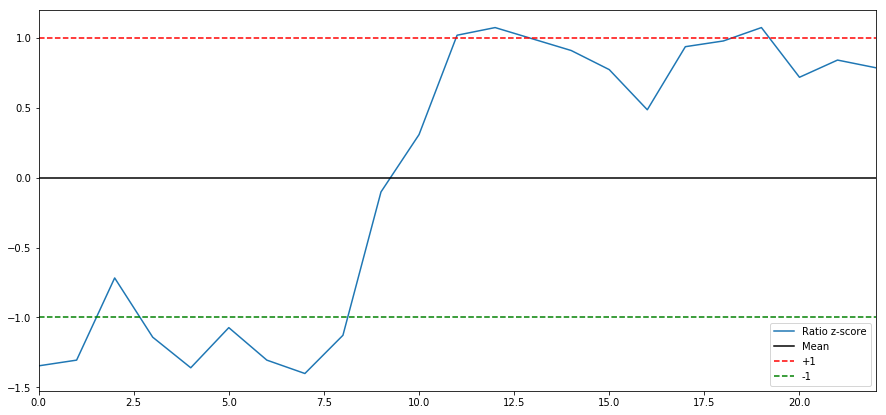

In [100]:
zscores = zscore(ratios)
zscores.plot(figsize=(15,7))
#print(zscores)
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

# Variables

In [101]:
# Indicators
moving_avg_1 = 40 #default 60
moving_avg_2 = 5 # default 5
macd_fast = 1
macd_slow = 2

# Trading limits
limit = 0.75 #default 1
exit_limit = 0.5 #default -.75
leverage_limit = 1.2
max_leverage = 2


# Identify features
- Slow Moving Average of Ratio: Check Variables
- Fast Moving Average of Ratio: Check Variables
- Standard Deviation (Based on Slow Moving AVG) 
- z score: (FastMA — SlowMA) / STD
- macd

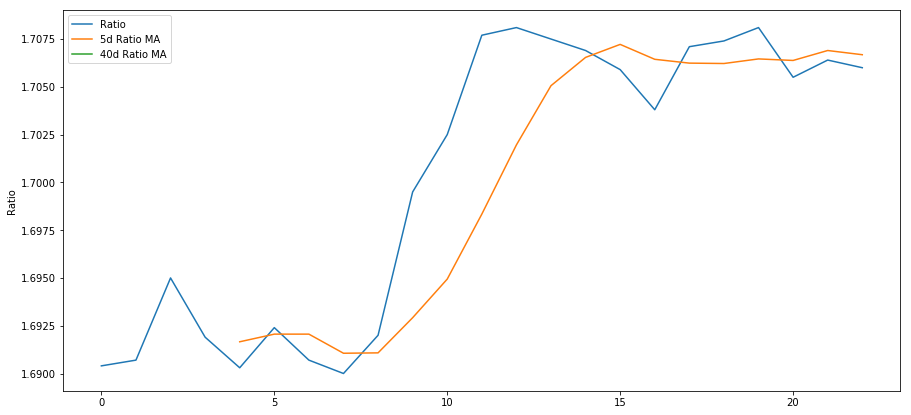

In [102]:
moving_avg_fast = ratios.rolling(window=moving_avg_2,
                               center=False).mean()
moving_avg_slow = ratios.rolling(window=moving_avg_1,
                               center=False).mean()
std_60 = ratios.rolling(window=moving_avg_1,
                        center=False).std()
zscore_moving_avg = (moving_avg_fast - moving_avg_slow)/std_60
plt.figure(figsize=(15,7))
plt.plot(ratios.index, ratios.values)
plt.plot(moving_avg_fast.index, moving_avg_fast.values)
plt.plot(moving_avg_slow.index, moving_avg_slow.values)
plt.legend(['Ratio',f'{moving_avg_2}d Ratio MA', f'{moving_avg_1}d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

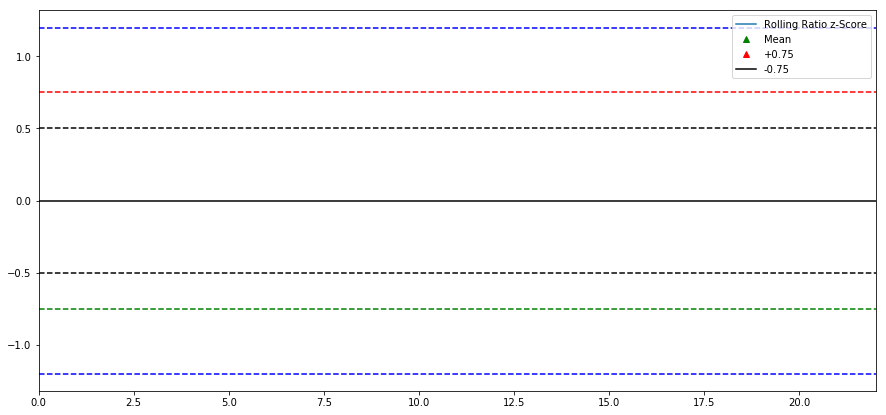

In [103]:
plt.figure(figsize=(15,7))
zscore_moving_avg.plot()

#buy_with_leverage = zscore_moving_avg.copy()
#buy_with_leverage[zscore_moving_avg>-leverage_limit] = None

#sell_with_leverage = zscore_moving_avg.copy()
#sell_with_leverage[zscore_moving_avg<leverage_limit] = None

buy = zscore_moving_avg.copy()
buy[zscore_moving_avg>-limit] = None

sell = zscore_moving_avg.copy()
sell[zscore_moving_avg<limit] = None

buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')


#buy_with_leverage.plot(color='black', linestyle='None', marker='^')
#sell_with_leverage.plot(color='black', linestyle='None', marker='^')

plt.axhline(0, color='black')
plt.axhline(limit, color='red', linestyle='--')
plt.axhline(-limit, color='green', linestyle='--')
plt.axhline(leverage_limit, color='blue', linestyle='--')
plt.axhline(-leverage_limit, color='blue', linestyle='--')
plt.axhline(exit_limit, color='black', linestyle='--')
plt.axhline(-exit_limit, color='black', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+'+str(limit), '-'+str(limit)])
plt.show()

In [104]:
zscores_frame = zscore_moving_avg.to_frame()
#print(zscores_frame)
macd_high = zscore_moving_avg.ewm(span=macd_fast, adjust=False).mean()
macd_low = zscore_moving_avg.ewm(span=macd_slow, adjust=False).mean()
#macd_high = exp1-exp2
#macd_low = macd.ewm(span=9, adjust=False).mean()


plt.figure(figsize=(15,7))
fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=macd_high.index, y=macd_high,
                    mode='lines',
                    name='high'))

fig.add_trace(go.Scatter(x=macd_low.index, y=macd_low,
                    mode='lines',
                    name='low'))



fig.show()

<Figure size 1080x504 with 0 Axes>

## Trading algo

In [87]:
def get_holding_return_on_close(holding):
    if holding['type'] == 'BUY':
        holding['return'] = (holding['sold_at'] / holding['bought_at'] -1) * holding['leverage']
    else:
        holding['return'] = (1 - holding['sold_at'] / holding['bought_at'])  * holding['leverage']
    holding['nav'] = holding['amount'] + (holding['return'] * holding['amount'])
    return holding


In [88]:
def get_open_holding_nav(holding, current_price):
    if holding['type'] == 'BUY':
        holding['return'] = (current_price / holding['bought_at'] -1) * holding['leverage']
    else:
        holding['return'] = (1 - current_price / holding['bought_at']) * holding['leverage']
    holding['nav'] = holding['amount'] + (holding['return'] * holding['amount'])
    return holding['nav']

In [89]:
# Trade using a simple strategy
# If window length is 0, algorithm doesn't make sense, so exit
def trade(S1, S2):
    portfolio = {
        'cash': 10000,
        'nav': 10000,
        'holdings': {
            's1': None,
            's2': None
        },
        'history': pd.DataFrame(columns=["symbol", "type", "amount", "bought_at", "bought_on", "status"]),
        'nav': pd.DataFrame(columns=['date', 'nav'])
    }
    prices = pd.DataFrame(columns=["Date", "Action", "Price"])
    
    old_trend = ""
    new_trend = ""
    indicator = zscore_moving_avg
    for i in range(len(indicator)):
        
        if macd_low[indicator.index[i]] <= macd_high[indicator.index[i]]:
            new_trend = "UP"
        else:
            new_trend = "DOWN"
            
       # dates.append
        # Sell short if the z-score is > 1
        if indicator[i] > limit and new_trend == "DOWN":
            if portfolio['holdings']['s1'] == None and portfolio['holdings']['s2'] == None:
                amount = portfolio['cash'] * 0.5
                leverage = 1
                if indicator[i] > leverage_limit:
                    leverage = max_leverage
                    
                portfolio['holdings']['s1'] = {'amount': amount, 'bought_at': S1.loc[indicator.index[i]], 'type': 'SELL', 'bought_on': indicator.index[i], 'symbol': chosen[0], 'status': 'OPEN', 'leverage': leverage}
                portfolio['holdings']['s2'] = {'amount': amount, 'bought_at': S2.loc[indicator.index[i]], 'type': 'BUY', 'bought_on': indicator.index[i], 'symbol': chosen[1], 'status': 'OPEN', 'leverage': leverage}
                portfolio['cash'] = portfolio['cash'] - amount*2
                
        # Buy long if the z-score is < 1
        elif indicator[i] < -limit and new_trend == "UP":
            if portfolio['holdings']['s1'] == None and portfolio['holdings']['s2'] == None:
                amount = portfolio['cash'] * 0.5
                leverage = 1
                if indicator[i] < -leverage_limit:
                    leverage = max_leverage
                    
                portfolio['holdings']['s1'] = {'amount': amount, 'bought_at': S1.loc[indicator.index[i]], 'type': 'BUY', 'bought_on': indicator.index[i], 'symbol': chosen[0], 'status': 'OPEN', 'leverage': leverage}
                portfolio['holdings']['s2'] = {'amount': amount, 'bought_at': S2.loc[indicator.index[i]], 'type': 'SELL', 'bought_on': indicator.index[i], 'symbol': chosen[1], 'status': 'OPEN', 'leverage': leverage}
                portfolio['cash'] = portfolio['cash'] - amount*2
        
        # Clear positions if the z-score between -.5 and .5
        elif abs(indicator[i]) < exit_limit:
            if portfolio['holdings']['s1'] != None and portfolio['holdings']['s2'] != None:
                s1_res =  portfolio['holdings']['s1']
                s1_res['sold_on'] =  indicator.index[i]
                s1_res['sold_at'] =  S1.loc[indicator.index[i]]
                s1_res['status'] = 'CLOSE'
                s1_res = get_holding_return_on_close(s1_res)
                
                s2_res =  portfolio['holdings']['s2']
                s2_res['sold_on'] =  indicator.index[i]
                s2_res['sold_at'] =  S2.loc[indicator.index[i]]
                s2_res['status'] = 'CLOSE'
                s2_res = get_holding_return_on_close(s2_res)

                portfolio['cash'] = s1_res['nav'] + s2_res['nav']
                
                portfolio['nav'] = portfolio['nav'].append({'date': indicator.index[i], 'nav': portfolio['cash']}, ignore_index=True)

                portfolio['history'] = portfolio['history'].append(s1_res, ignore_index=True)
                portfolio['history'] = portfolio['history'].append(s2_res, ignore_index=True)

                portfolio['holdings']['s1'] = None
                portfolio['holdings']['s2'] = None

                #print('Exit')
        
        holdings_nav = 0
        if portfolio['holdings']['s1'] != None and portfolio['holdings']['s2'] != None:
            s1_nav = get_open_holding_nav(portfolio['holdings']['s1'], S1.loc[indicator.index[i]])
            s2_nav = get_open_holding_nav(portfolio['holdings']['s2'], S2.loc[indicator.index[i]])
            holdings_nav = s1_nav + s2_nav

        portfolio['nav'] = portfolio['nav'].append({'date': indicator.index[i], 'nav': portfolio['cash'] + holdings_nav}, ignore_index=True)
        
        old_trend = new_trend
        #print(portfolio['history'])
            
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
    
    portfolio['nav'] = portfolio['nav'].set_index('date')
    return portfolio

portfolio = trade(quotes[chosen[0]],quotes[chosen[1]])



In [90]:
normalized_nav = pd.DataFrame(portfolio['nav'])
normalized_nav = normalized_nav.reset_index()
normalized_nav['nav'] = normalized_nav['nav'] / normalized_nav['nav'].iloc[0]
normalized_nav = normalized_nav.set_index('date')

returns = np.log(portfolio['nav'] / portfolio['nav'].shift(1))
vol = returns.std() * 250 ** 0.5
print(vol)

#print(portfolio['nav'].std() * np.sqrt(252) )

nav    0.003003
dtype: float64


In [91]:
normalized_S1 = S1.apply(lambda x: x / S1[0])
normalized_S2 = S2.apply(lambda x: x / S2[0])
normalized_nav = pd.DataFrame(portfolio['nav'])
normalized_nav = normalized_nav.reset_index()
normalized_nav['nav'] = normalized_nav['nav'] / normalized_nav['nav'].iloc[0]
normalized_nav = normalized_nav.set_index('date')


fig = go.Figure()
fig.add_trace(go.Scatter(x=normalized_S1.index, y=normalized_S1,
                    mode='lines',
                    name='benchmark'))
fig.add_trace(go.Scatter(x=normalized_nav.index, y=normalized_nav['nav'],
                    mode='lines',
                    name='strategy'))

fig.show()


In [92]:
nav = ratios.to_frame()
#print(nav)
history = portfolio['history']

history = history[history['symbol'] == chosen[0]]
trades = pd.DataFrame(columns=["Type" "BoughtOn", "SoldOn", "Return"])
trades['Type'] = history["type"]
trades['BoughtOn'] = history['bought_on']
trades['SoldOn'] = history['sold_on']
trades['Return'] = history['return']

bought_on = trades['BoughtOn'].to_frame()
bought_on['Type'] = trades['Type']
bought_on.columns = ['date', 'type']
bought_on.set_index('date', inplace=True)
nav = nav.join(bought_on)

sold_on = trades['SoldOn'].to_frame()
sold_on['exit'] = "Exit"
sold_on.columns = ['date', 'exit']
sold_on['exit'] = "Exit"
sold_on.set_index('date', inplace=True)

bought = nav[nav['type'] == 'BUY']
sold_on = nav[nav['type'] == 'SELL']


In [93]:
def plot_returns(ret):
    #tot_return['date'] = pd.to_datetime(tot_return.index)
    fig = px.line(ret, x=ret.index, y='nav')
    fig.show()


In [94]:
plot_returns(portfolio['nav'])

In [56]:
new_ratios = zscore_moving_avg.to_frame()
#print(new_zscores)
history = portfolio['history']

history = history[history['symbol'] == chosen[1]]
trades = pd.DataFrame(columns=["Type" "BoughtOn", "SoldOn", "Return"])
trades['Type'] = history["type"]
trades['BoughtOn'] = history['bought_on']
trades['SoldOn'] = history['sold_on']
trades['Return'] = history['return']

bought_on = trades['BoughtOn'].to_frame()
bought_on['Type'] = trades['Type']
bought_on.columns = ['Date', 'Type']
bought_on.set_index('Date', inplace=True)
new_ratios = new_ratios.join(bought_on)

sold_on = trades['SoldOn'].to_frame()
sold_on['exit'] = "Exit"
sold_on.columns = ['Date', 'exit']
sold_on['Exit'] = "EXIT"
sold_on.set_index('Date', inplace=True)
new_ratios = new_ratios.join(sold_on)

bought_zscore = new_ratios[new_ratios['Type'] == 'BUY']
sold_zscore = new_ratios[new_ratios['Type'] == 'SELL']
exit_zscore =  new_ratios[new_ratios['Exit'] == 'EXIT']
#print(sold_zscore)
#print(new_zscores.loc['2010-09-20'])

In [57]:
plt.figure(figsize=(15,7))

#print(bought_zscore)
#print(new_zscores)
fig = go.Figure()
fig.add_trace(go.Scatter(x=new_ratios.index, y=new_ratios[0],
                    mode='lines',
                    name='ratios'))

fig.add_trace(go.Scatter(x=bought_zscore.index, y=bought_zscore[0],
                    mode='markers',
                    name='sell'))

fig.add_trace(go.Scatter(x=sold_zscore.index, y=sold_zscore[0],
                    mode='markers',
                    name='buy'))

fig.add_trace(go.Scatter(x=exit_zscore.index, y=exit_zscore[0],
                    mode='markers',
                    name='exit'))
fig.show()

<Figure size 1080x504 with 0 Axes>